In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV 




In [3]:
# Import datasets
returns = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Returns_Clean.xlsx", index_col = 'Dates')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')
flows = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Flows_Clean.xlsx", index_col = 'Dates')
flows.index = pd.to_datetime(flows.index, format='%Y%m%d')
returns

,55976,41072,27748,75259,40970,62519,21792,54084,55511,10302,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
Dates,,,,,,,,,,,,,,,,,,,,,
1993-04-01,-0.019685,0.019391,-0.007282,-0.003891,0.083333,0.027027,0.005348,0.020000,-0.010417,-0.025000,...,0.108108,-0.019048,-0.017857,-0.028269,0.000000,0.006173,-0.023669,0.000000,0.031915,0.014433
1993-04-02,-0.020080,0.002717,-0.002445,0.058594,-0.038462,-0.026316,-0.007979,-0.019608,-0.021053,-0.025641,...,0.000000,-0.016181,-0.031818,-0.010909,0.000000,-0.020450,0.012121,-0.032609,0.020619,-0.010163
1993-04-05,-0.024590,-0.006775,-0.002451,0.022140,-0.040000,0.027027,0.005362,0.000000,0.021505,0.026316,...,-0.048780,-0.003289,0.032864,0.003676,-0.005102,0.018789,-0.005988,-0.011236,-0.010101,0.026694
1993-04-06,-0.067227,0.009550,-0.007371,0.025271,0.041667,0.052632,0.005333,0.000000,0.000000,0.038462,...,-0.025641,-0.023102,-0.009091,-0.007326,0.005128,0.002049,-0.024096,-0.011364,-0.010204,0.014000
1993-04-07,0.000000,0.005405,0.000000,0.021127,0.040000,-0.050000,0.002653,0.000000,0.010526,0.012346,...,-0.013158,0.016892,0.018349,0.000000,0.010204,0.014315,0.000000,0.011494,0.000000,0.005917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,0.014493,0.025678,0.003630,0.077551,0.000000,0.011811,-0.004354,0.035714,0.012285,0.069767,...,0.000000,0.016418,-0.007426,-0.021622,-0.029727,-0.006281,0.002066,0.100446,-0.010989,0.026415
2000-12-26,-0.035714,0.034771,0.007233,-0.056818,-0.063830,0.060311,0.029155,-0.034483,0.026699,0.006211,...,0.027027,0.004405,0.034913,0.024171,0.026961,0.022756,-0.008247,-0.034483,-0.027778,0.003676
2000-12-27,0.038272,0.001344,0.001795,0.000000,0.090909,-0.042202,0.000000,-0.035714,0.021277,0.015432,...,0.052632,0.038012,0.069880,0.000000,0.047733,0.014833,0.022869,0.027311,0.005714,0.028083


In [5]:
# add skewness of return as a predictor variable
# because we think that eventually stocks' returns converge to their own distribution (not normal)
# and any divergence from that distribution can give us some predictive power
from scipy.stats import skew 

n=50
for i in range(len(returns.columns)):
    returns['skewness_{}'.format(returns.columns[i])] = returns[returns.columns[i]].rolling(window=n).skew()

In [6]:
# add momentum_20_50 and momentum_8_20 as a predictor variable
# momentum_8_20: if 8-day MA crosses 20-day MA, we created a new variable as 1
# momentum_20_50: if 20-day MA crosses 50-day MA, we created a new variable as 1


for j in range(len(returns.columns[:100])):
    returns['momentum_20_50_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['momentum_8_20_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(49, len(returns[returns.columns[j]])):
        if returns[returns.columns[j]][i-19:i+1].mean() > returns[returns.columns[j]][i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(returns.columns[j])][i] = 1
        if returns[returns.columns[j]][i-19:i+1].mean() < returns[returns.columns[j]][i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(returns.columns[j])][i] = 0
        if returns[returns.columns[j]][i-7:i+1].mean() > returns[returns.columns[j]][i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(returns.columns[j])][i] = 1
        if returns[returns.columns[j]][i-7:i+1].mean() < returns[returns.columns[j]][i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(returns.columns[j])][i] = 0

In [7]:
# Add distance to min and max values in the last N-period
# We created stock prices using the returns
# disttop: distance of the current price to the max price in the last N-period (including the current price)
# distbottom: distance of the current price to the min price in the last N-period (including the current price)
# the reason why we added these variables is that, from behavioural perspective, when the investors look at the chart
# they can sometimes be misled by the highest or lowest prices the stock reached in the past


n=50
for j in range(len(returns.columns[:100])):
    returns['distbottom_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['disttop_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['cumulative_{}'.format(returns.columns[j])] = np.cumprod(1 + returns[returns.columns[j]].values)
    
    for i in range(49, len(returns[returns.columns[j]])):
        returns['distbottom_{}'.format(returns.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i]- returns['cumulative_{}'.format(returns.columns[j])][i-n+1:i+1].min()) /returns['cumulative_{}'.format(returns.columns[j])][i]
        returns['disttop_{}'.format(returns.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i-n+1:i+1].max()- returns['cumulative_{}'.format(returns.columns[j])][i])/returns['cumulative_{}'.format(returns.columns[j])][i]


In [8]:
def rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
    
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [9]:
# This generates a variable that contains Relative Strength Index (RSI) values for the stock price
# Technical indicators perhaps do not have any scientific grounds, however, they create some kind of a
# self-fulfiling prophecy as many traders make decisions based on these so-called technical indicators

for j in range(len(returns.columns[:100])):
    returns['rsi_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['rsi_{}'.format(returns.columns[j])] = rsi(returns['cumulative_{}'.format(returns.columns[j])])
        

In [10]:
# Change in RSI values

for j in range(len(returns.columns[:100])):
    returns['rsi_change_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['rsi_change_{}'.format(returns.columns[j])] = returns['rsi_{}'.format(returns.columns[j])].pct_change()

In [24]:
# MACD(12,26) technical indicator for RSI values (not stock prices)
# if the last 12-day value is larger than the last 26-day value, feature assigned as 1

for j in range(len(returns.columns[:100])):
    returns['macd_rsi_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(25, len(returns[returns.columns[j]])):
        if returns['rsi_{}'.format(returns.columns[j])][i-11:i+1].mean() > returns['rsi_{}'.format(returns.columns[j])][i-25:i+1].mean():
            returns['macd_rsi_{}'.format(returns.columns[j])][i] = 1
        if returns['rsi_{}'.format(returns.columns[j])][i-11:i+1].mean() < returns['rsi_{}'.format(returns.columns[j])][i-22:i+1].mean():
            returns['macd_rsi_{}'.format(returns.columns[j])][i] = 0

In [11]:
# Stochastic oscillator is also a very common technical analysis tool that many traders look at
# This is not the real stochastic oscillator we created here since the original function also needs highest and lowest
# prices that the stock reached in the past (we don't have that data)
# However, we the function we created is very close to the original stochastic oscillator, and we thought it can be a good predictor

def stochastic(prices, n=14):
    stochastic = np.zeros(shape=(1958,1))
    for i in range(n, len(prices)):
        stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100
    return stochastic

In [12]:
for j in range(len(returns.columns[:100])):
    returns['stochastic_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['stochastic_{}'.format(returns.columns[j])] = stochastic(returns['cumulative_{}'.format(returns.columns[j])])

<ipython-input-11-a6053d53f22a>:4: RuntimeWarning: invalid value encountered in double_scalars
  stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100
<ipython-input-11-a6053d53f22a>:4: RuntimeWarning: divide by zero encountered in double_scalars
  stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100


In [13]:
# (total flows in the last month)*(total return in the last month)
# 20 days = trading days in one month

for j in range(len(returns.columns[:100])):
    returns['20dayflow_times_return_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))

    for i in range(4, len(returns[returns.columns[j]])):
    
        total_returns_in_20_days = (returns['cumulative_{}'.format(returns.columns[j])][i] - returns['cumulative_{}'.format(returns.columns[j])][i-20])/returns['cumulative_{}'.format(returns.columns[j])][i-20]
        returns['20dayflow_times_return_{}'.format(flows.columns[j])][i] = total_returns_in_20_days * flows[returns.columns[j]][i-19:i+1].sum()  
        
        

In [14]:
# Bollinger bands are also technical indicators that traders often take into account
# dist_top_band = (top bollinger band - current price)/ (current price)
# dist_top_band = (current price - bottom bollinger band)/ (current price)


for j in range(len(returns.columns[:100])):
    returns['dist_top_band_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    returns['dist_bottom_band_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    for i in range(19, len(returns[returns.columns[j]])):
        std = returns['cumulative_{}'.format(returns.columns[j])][i-19:i+1].std()
        mean = returns['cumulative_{}'.format(returns.columns[j])][i-19:i+1].mean()
        bollinger_top = mean + 2*std
        bollinger_bottom = mean - 2*std
        returns['dist_top_band_{}'.format(flows.columns[j])][i] = (bollinger_top - returns['cumulative_{}'.format(returns.columns[j])][i])/returns['cumulative_{}'.format(returns.columns[j])][i]
        returns['dist_bottom_band_{}'.format(flows.columns[j])][i] = (returns['cumulative_{}'.format(returns.columns[j])][i] - bollinger_bottom)/returns['cumulative_{}'.format(returns.columns[j])][i]

In [15]:
def difference_from_mean(prices, n=50):
    difference = np.zeros(shape=(1958,1))
    for i in range(n, len(prices)):
        difference[i] = prices[i] - prices[i-n:i].mean()/prices[i]
    return difference

In [16]:
# Stocks often have mean reversion patterns, but the distance to the N-period mean price matters for predictions?
# difference_from_mean = (current price - last N-period mean) ... today's price is not included

for j in range(len(returns.columns[:100])):
    returns['difference_from_mean_{}'.format(returns.columns[j])] = np.zeros(shape=(1958,1))
    returns['difference_from_mean_{}'.format(returns.columns[j])] = difference_from_mean(returns[returns.columns[j]])

In [17]:
# Average flows in the last month

for j in range(len(returns.columns[:100])):
    returns['flows_average_last_month_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
    
    for i in range(19, len(returns[returns.columns[j]])):

        returns['flows_average_last_month_{}'.format(flows.columns[j])][i] = flows[flows.columns[j]][i-19:i+1].mean()

In [18]:
# Total returns in the last month

for j in range(len(returns.columns[:100])):
    returns['returns_total_last_month_{}'.format(flows.columns[j])] = np.zeros(shape=(1958,1))
   
    for i in range(19, len(returns[returns.columns[j]])):
        total_returns_in_20_days = (returns['cumulative_{}'.format(returns.columns[j])][i] - returns['cumulative_{}'.format(returns.columns[j])][i-20])/returns['cumulative_{}'.format(returns.columns[j])][i-20]
        returns['returns_total_last_month_{}'.format(flows.columns[j])][i] = total_returns_in_20_days

In [71]:
# Lags of stock's own return

for j in range(len(returns.columns[:100])):
    returns['lag1_return_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(1)
    returns['lag2_return_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(2)
    returns['lag3_return_{}'.format(returns.columns[j])] = returns[returns.columns[j]].shift(3)

In [72]:
# Lags of stock's own flows

for j in range(len(returns.columns[:100])):
    returns['lag1_flow_{}'.format(returns.columns[j])] = flows[returns.columns[j]].shift(1)
    returns['lag2_flow_{}'.format(returns.columns[j])] = flows[returns.columns[j]].shift(2)
    returns['lag3_flow_{}'.format(returns.columns[j])] = flows[returns.columns[j]].shift(3)

In [886]:
# since I will use the variables starting from the 50th index
# and will use lagged values of them, i decided to take it starting from 49th index
# since there will be NA values after the lag, when i delete the NA values, my index will be starting from 50
df = returns.iloc[49:,]

In [887]:
g = globals()

In [888]:
#Shifting everything as we will use them for prediction
# df_(stock number) creates dataframe of features for each stock 
for j in returns.columns[:100]:
    if j == 32299:
        continue
    # add the lagged values of variables for prediction
    g['df_{}'.format(j)] = pd.DataFrame([])
    g['df_{}'.format(j)]['skewness'] = df['skewness_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['momentum_20_50'] = df['momentum_20_50_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['momentum_8_20'] = df['momentum_8_20_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['distbottom'] = df['distbottom_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['disttop'] = df['disttop_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['rsi'] = df['rsi_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['rsi_change'] = df['rsi_change_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['macd_rsi'] = df['macd_rsi_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['stochastic'] = df['stochastic_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['dist_top_band'] = df['dist_top_band_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['dist_bottom_band'] = df['dist_bottom_band_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['difference_from_mean'] = df['difference_from_mean_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['20dayflow_times_return'] = df['20dayflow_times_return_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['flows_average_last_month'] = df['flows_average_last_month_{}'.format(j)].shift(1)[1:]
    g['df_{}'.format(j)]['returns_total_last_month'] = df['returns_total_last_month_{}'.format(j)].shift(1)[1:]
      
    #add the lags without shifting, because they are already lagged values
    g['df_{}'.format(j)]['lag1_return_{}'.format(j)] = df['lag1_return_{}'.format(j)]
    g['df_{}'.format(j)]['lag2_return_{}'.format(j)] = df['lag2_return_{}'.format(j)]
    g['df_{}'.format(j)]['lag3_return_{}'.format(j)] = df['lag3_return_{}'.format(j)]
    
    g['df_{}'.format(j)]['lag1_flow_{}'.format(j)] = df['lag1_flow_{}'.format(j)]
    g['df_{}'.format(j)]['lag2_flow_{}'.format(j)] = df['lag2_flow_{}'.format(j)]
    g['df_{}'.format(j)]['lag3_flow_{}'.format(j)] = df['lag3_flow_{}'.format(j)]

    g['df_{}'.format(j)]['return'] = np.zeros(shape=(len(g['df_{}'.format(j)]),1))
            
# I added the returns of the stocks, the reason i did that df[j][i+1] because df_number and df has different lengths
# It is in the correct form that the returns are in their normal index and the features are shifted
    for i in range(len(g['df_{}'.format(j)])):
        g['df_{}'.format(j)]['return'][i] = df[j][i+1]


In [889]:
for j in returns.columns[:100]:
    if j == 32299:
        continue
    columns = list(returns.columns[:100])
    columns.remove(j)
    columns.remove(32299)
    others = columns
    for k in others:
        g['df_{}'.format(j)]['lag1_return_{}'.format(k)] = g['df_{}'.format(k)]['lag1_return_{}'.format(k)]
        g['df_{}'.format(j)]['lag2_return_{}'.format(k)] = g['df_{}'.format(k)]['lag2_return_{}'.format(k)]
        g['df_{}'.format(j)]['lag3_return_{}'.format(k)] = g['df_{}'.format(k)]['lag3_return_{}'.format(k)]

In [890]:
df_55976.shape

(1908, 316)

In [891]:
# Visualize the Mean squre error on each fold 
# plot the mse & log(alphas) in LASSO model
# inputs: stock index and its LASSO model

def plot_mse(i, LASSO_model):
    
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    # Display results
    m_log_alphas = -np.log10(LASSO_model.alphas_ + EPSILON)
    # print(m_log_alphas)

    plt.figure()
    plt.plot(m_log_alphas, LASSO_model.mse_path_, ':')
    plt.plot(m_log_alphas, LASSO_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(LASSO_model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold for stock ' + str(i))
    plt.axis('tight')

In [892]:
# Preprocessing the datasets

# the combine of returns and flows of stocks
S = df_55976
# print(S.describe())

# Standardize the dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(S), columns = S.columns)


In [893]:
n_alphas = 20
alphas = np.logspace(4.5, -5, n_alphas)
alphas = alphas.tolist()

# it's too computationally expensive, so after various runs, we decided to use a more appropriate range of penalty terms
# since the pen


       R squared
55976   0.000698


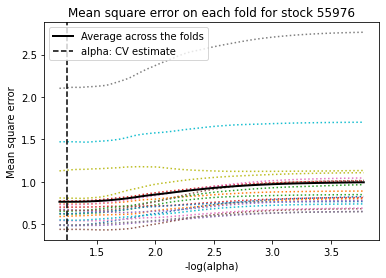

In [895]:
# Using first stock 55976 to demonstrate the process
#y1 = r_i_t is the variable to predict
# R_Squared result is pretty consistent with the papers we have seen in the class
# R_Squared in the slide is different because we used class of the return for Y values
# Return is more difficult to predict than class, because even if you randomly guess that the result will be between -2% and +2%
# You can have 70% correct predictions (oversampling)

l = returns.columns[0]
y1 = scaled_data['return']
X1_full = scaled_data.drop(['return'], axis=1)
# split the training and test dataset using X_full
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_full, y1, test_size=0.2, random_state=0, shuffle = False)

#     Lasso model with cross-validation of 20-fold
LASSO_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 20)
model = LASSO_model.fit(X1_train, y1_train)
R_squared = pd.DataFrame([model.score(X1_test, y1_test)], index = [l], columns = ['R squared'])
# print(LASSO_model.score(X1_test, y1_test))
print(R_squared)
# print(LASSO_model.coef_)
# print(LASSO_model.alpha_
# print(LASSO_model.alphas_)
plot_mse(l, LASSO_model)

In [820]:
# Here we didn't do rolling window regression. Instead, we did LASSO on full time series of each stock
# If one wishes to use individual stocks and predict their returns using rolling window, we showed how to do that
# in the coming cells, but using an equal weighted index as we are inspired by many papers we've read about them
# We used equal weighted index because it's almost the most efficient and hard to beat index
# Running ML models with rolling window on 100 stocks is time consuming

# All the stock has its own dataframe of variables, for example df_55976, df_41072 etc. has all the variables for prediction
# With a simple loop, one can loop over 100 stocks + use rolling window 
# (we tried it at first but decided to exclude it from here, because it's all mess --> efficent solution is equally weighted index)

LASSO_models = []
LASSO_scores = []
LASSO_mses = []
LASSO_rmse = []
# print(X.iloc[:len(returns)-1])
for i in tqdm(returns.columns[0:100]):
    if i == 32299:
        continue
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(g['df_{}'.format(i)] ), columns = g['df_{}'.format(i)].columns)
    y = scaled_data['return']
    predictors = scaled_data
    X_full = predictors.drop(['return'], axis=1)
    
#   split the training and test dataset using X_full
    X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=0, shuffle = False)

#     Lasso model using cross-validation of 20-fold
    LASSO_model = LassoCV(n_alphas=n_alphas, alphas=alphas, fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 20)
    LASSO_model.fit(X_train, y_train)
#     LASSO_model.predict(X_test)
    score = {i : LASSO_model.score(X_test, y_test)}
    LASSO_scores.append(score)
    LASSO_models.append(LASSO_model)
    y_pred = LASSO_model.predict(X_test)
    mse = {i : mean_squared_error(y_pred, y_test)}
    sqrt_mse = {i : sqrt(mean_squared_error(y_pred, y_test))}
    LASSO_mses.append(mse)
    LASSO_rmse.append(sqrt_mse)

In [640]:
LASSO_alphas = [model.alpha_ for model in LASSO_models]
LASSO_coefs = [model.coef_ for model in LASSO_models]
#print(LASSO_coefs[1])
#print(LASSO_alphas[1])
#print(LASSO_scores)

# PREDICTIONS FOR EQUALLY WEIGHTED PORTFOLIO

In [986]:
# Label the returns and flows with its stock tickets for the convenience of feature extraction
returns_ = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Returns_Clean.xlsx", index_col = 'Dates')
returns_.drop(32299 ,axis =1, inplace = True)
returns_.index = pd.to_datetime(returns.index, format='%Y%m%d')
flows_ = pd.read_excel("/Users/alkanpamukcu/Desktop/big data/Flows_Clean.xlsx", index_col = 'Dates')
flows_.drop(32299 ,axis =1, inplace = True)
flows_.index = pd.to_datetime(flows.index, format='%Y%m%d')

returns_labeled = returns_.copy()
returns_labeled.columns =['return_'+str(i) for i in returns_.columns]
flows_labeled = flows_.copy()
flows_labeled.columns = ['flow_'+str(i) for i in flows_.columns]

# the combine of returns and flows of stocks
S = pd.concat([returns, flows], axis = 1)
S_labeled = pd.concat([returns_labeled, flows_labeled], axis = 1)

In [990]:
# Using the equally-weighted portfolio consisting with all 100 stocks to demonstrate the model
# The portfolio returns and flows are the average of all stocks
port_returns = pd.DataFrame(data = returns_.mean(axis=1), columns = ['Portfolio_returns'] )
# print(port_returns.head())
port_flows = pd.DataFrame(data = flows_.mean(axis = 1), columns = ['Portfolio_flows'])
# port_flows.head()
portfolio = pd.concat([port_returns, port_flows], axis = 1)
length = len(port_returns)
# generate predictor matrix for portfolio

# predictor matrix P_small, includes portfolio's own returns up to three lags and portfolio’s net trading flows up to three lags
P_small = pd.DataFrame()   
for j in range(1,4):
    p_t = port_returns.shift(j)
    p_t.columns = [str(j) + '_lag return_portfolio']
    f_t = port_flows.shift(j)
    f_t.columns = [str(j) + '_lag flow_portfolio']
    P_small = pd.concat([P_small, p_t], axis = 1)
    P_small = pd.concat([P_small, f_t], axis = 1)
    
    
#     generate full predictor variables matrix by adding all stock to P_small
P_full = pd.concat([P_small, S_labeled], axis = 1)

P_full.fillna(0, inplace=True)

In [980]:
P_small.to_csv('P_small.csv', index=True)

In [842]:
# DOING THE SAME PROCEDURES FOR EQUALLY WEIGHTED PORTFOLIO in the next cells
# Because we have discovered from our LASSO regressions on the stocks that our features can lead to good results

n=50

P_full['skewness'] = port_returns.rolling(window=n).skew()
# print(P_full['skewness'])

In [843]:
P_full['momentum_20_50'] = np.zeros(shape=(length,1))
P_full['momentum_8_20'] = np.zeros(shape=(length,1))  
# print(type(port_returns))
for i in range(49, length):
    if portfolio.Portfolio_returns[i-19:i+1].mean() > portfolio.Portfolio_returns[i-49:i+1].mean():
        P_full['momentum_20_50'][i] = 1
    if portfolio.Portfolio_returns[i-19:i+1].mean() < portfolio.Portfolio_returns[i-49:i+1].mean():
        P_full['momentum_20_50'][i] = 0
    if portfolio.Portfolio_returns[i-7:i+1].mean() > portfolio.Portfolio_returns[i-19:i+1].mean():
        P_full['momentum_8_20'][i] = 1
    if portfolio.Portfolio_returns[i-7:i+1].mean() < portfolio.Portfolio_returns[i-19:i+1].mean():
        P_full['momentum_8_20'][i] = 0

P_full['momentum_20_50'].tail(10)

Dates
2000-12-15    0.0
2000-12-18    0.0
2000-12-19    0.0
2000-12-20    0.0
2000-12-21    0.0
2000-12-22    0.0
2000-12-26    0.0
2000-12-27    1.0
2000-12-28    1.0
2000-12-29    1.0
Name: momentum_20_50, dtype: float64

In [844]:
n = 50

P_full['distbottom'] = np.zeros(shape=(length,1))
P_full['disttop'] = np.zeros(shape=(length,1))
P_full['cumulative'] = np.cumprod(1 + portfolio.Portfolio_returns.values)

for i in range(49, length):
    P_full['distbottom'][i] = (P_full['cumulative'][i]- P_full['cumulative'][i-n+1:i+1].min()) / P_full['cumulative'][i]
    P_full['disttop'][i] = (P_full['cumulative'][i-n+1:i+1].max()- P_full['cumulative'][i])/P_full['cumulative'][i]

# print(P_full['cumulative'])
# print(P_full['disttop'])

In [845]:
P_full['rsi'] = np.zeros(shape=(length,1))
P_full['rsi'] = rsi(P_full['cumulative'])
# print(P_full['rsi'])


# Percentage change in RSI values may be a good indicator, too
P_full['rsi_change'] = np.zeros(shape=(length,1))
P_full['rsi_change'] = P_full['rsi'].pct_change()

# print(P_full['rsi_change'])


In [846]:
P_full['macd_rsi'] = np.zeros(shape=(length,1))

for i in range(25, length):
    if P_full['rsi'][i-11:i+1].mean() > P_full['rsi'][i-25:i+1].mean():
        P_full['macd_rsi'][i] = 1
    if P_full['rsi'][i-11:i+1].mean() < P_full['rsi'][i-22:i+1].mean():
        P_full['macd_rsi'][i] = 0

# print(P_full['macd_rsi'])

In [847]:
def stochastic(prices, n=14):
    stochastic = np.zeros(shape=(length,1))
    for i in range(n, len(prices)):
        stochastic[i] = ((prices[i]-prices[i-n:i].min())/(prices[i-n:i].max()-prices[i-n:i].min()))*100
    return stochastic

P_full['stochastic'] = np.zeros(shape=(length,1))
P_full['stochastic'] = stochastic(P_full['cumulative'])

# print(P_full['stochastic'])

In [848]:
P_full['flow_times_return'] = np.zeros(shape=(length,1))
P_full['5dayflow_times_return'] = np.zeros(shape=(length,1))

for i in range(4, length):
    P_full['flow_times_return'][i] = portfolio.Portfolio_returns[i] * portfolio.Portfolio_flows[i]
    P_full['5dayflow_times_return'][i] = portfolio.Portfolio_returns[i-4:i+1].mean() * portfolio.Portfolio_flows[i-4:i+1].sum()  

# print(P_full['5dayflow_times_return'])

In [849]:
P_full['dist_top_band'] = np.zeros(shape=(length,1))
P_full['dist_bottom_band'] = np.zeros(shape=(length,1))

for i in range(19, length):
    std = P_full['cumulative'][i-19:i+1].std()
    mean = P_full['cumulative'][i-19:i+1].mean()
    bollinger_top = mean + 2*std
    bollinger_bottom = mean - 2*std
    P_full['dist_top_band'][i] = (bollinger_top - P_full['cumulative'][i])/P_full['cumulative'][i]
    P_full['dist_bottom_band'][i] = (P_full['cumulative'][i] - bollinger_bottom)/P_full['cumulative'][i]

In [850]:
def difference_from_mean(prices, n=50):
    difference = np.zeros(shape=(length,1))
    for i in range(n, len(prices)):
        difference[i] = (prices[i] - prices[i-n:i].mean())/prices[i]
    return difference

P_full['difference_from_mean'] = np.zeros(shape=(length,1))
P_full['difference_from_mean'] = difference_from_mean(portfolio.Portfolio_returns)

In [851]:
# For most of our indicators, we used rolling window of 50, so it's better to start from that index
P_full = P_full[50:]

In [852]:
# Of course, we are using the lagged values of our predictors, excluding the NA value with [1:] indexing
P_full['skewness'] = P_full['skewness'].shift(1)
P_full['momentum_20_50'] = P_full['momentum_20_50'].shift(1)
P_full['momentum_8_20'] = P_full['momentum_8_20'].shift(1)
P_full['distbottom'] = P_full['distbottom'].shift(1)
P_full['disttop'] = P_full['disttop'].shift(1)
P_full['rsi'] = P_full['rsi'].shift(1)
P_full['rsi_change'] = P_full['rsi_change'].shift(1)
P_full['macd_rsi'] = P_full['macd_rsi'].shift(1)
P_full['stochastic'] = P_full['stochastic'].shift(1)
P_full['flow_times_return'] = P_full['flow_times_return'].shift(1)
P_full['5dayflow_times_return'] = P_full['5dayflow_times_return'].shift(1)
P_full['dist_top_band'] = P_full['dist_top_band'].shift(1)
P_full['dist_bottom_band'] = P_full['dist_bottom_band'].shift(1)
P_full['difference_from_mean'] = P_full['difference_from_mean'].shift(1)

In [853]:
P_full = P_full[1:]

,1_lag return_portfolio,1_lag flow_portfolio,2_lag return_portfolio,2_lag flow_portfolio,3_lag return_portfolio,3_lag flow_portfolio,return_55976,return_41072,return_27748,return_75259,...,cumulative,rsi,rsi_change,macd_rsi,stochastic,flow_times_return,5dayflow_times_return,dist_top_band,dist_bottom_band,difference_from_mean
Dates,,,,,,,,,,,,,,,,,,,,,
1993-06-15,-0.005728,-0.129155,0.002173,-1.332499,-0.002723,-0.163292,-0.018519,0.036765,0.023196,-0.013100,...,0.995467,42.592914,-0.106918,1.0,-16.789191,0.000740,0.007740,0.026416,0.006104,-0.005731
1993-06-16,0.001744,0.438636,-0.005728,-0.129155,0.002173,-1.332499,-0.028302,0.031915,-0.002519,-0.066372,...,0.992957,44.526225,0.045390,0.0,7.573387,0.000765,0.000269,0.024004,0.006608,0.001812
1993-06-17,-0.002522,0.272253,0.001744,0.438636,-0.005728,-0.129155,0.004854,0.024055,-0.007576,-0.047393,...,0.992994,42.303770,-0.049913,0.0,-3.397033,-0.000686,0.001290,0.026391,0.003726,-0.002803
1993-06-18,0.000038,-1.371864,-0.002522,0.272253,0.001744,0.438636,-0.028986,0.000000,-0.010178,0.044776,...,0.989641,42.349771,0.001087,0.0,0.157499,-0.000051,0.001824,0.026668,0.005096,-0.000138
1993-06-21,-0.003377,-1.615099,0.000038,-1.371864,-0.002522,0.272253,0.000000,0.000000,-0.010283,0.042857,...,0.992296,39.312262,-0.071724,0.0,-14.015594,0.005454,0.004736,0.030657,0.003656,-0.003616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,0.011171,0.587265,-0.017832,0.677784,-0.000126,-0.615457,0.014493,0.025678,0.003630,0.077551,...,3.258379,48.886198,0.106940,1.0,25.560975,0.006560,0.000184,0.030507,0.022712,0.010539
2000-12-26,0.020620,1.558308,0.011171,0.587265,-0.017832,0.677784,-0.035714,0.034771,0.007233,-0.056818,...,3.268758,56.313607,0.151933,1.0,73.269958,0.032133,0.008826,0.011583,0.042530,0.019535
2000-12-27,0.003185,-0.115275,0.020620,1.558308,0.011171,0.587265,0.038272,0.001344,0.001795,0.000000,...,3.351101,57.365479,0.018679,1.0,80.791693,-0.000367,0.007122,0.010640,0.045720,0.001419


In [864]:
# rolling window of 50 and excluding NA values, starting the index from 51
port_returns = port_returns[51:]

In [854]:
# Standardize the dataset
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(P_full), columns = P_full.columns)

In [866]:
scaled_port_returns = pd.DataFrame(scaler.fit_transform(port_returns), columns = port_returns.columns)

In [898]:
# rolling window
py = scaled_port_returns

window_size = 252

dates = []
LASSO_models_p = []
LASSO_predict = []
LASSO_y_test = []
historical_mean = []
LA_mse_p = []
LA_rmse_p = []

scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(P_full), columns = P_full.columns)

for n in range(1, len(scaled_data)-window_size):
    dates.append(portfolio.index[n])
    n_train = P_full.iloc[n:n+window_size]
    n_test = P_full.iloc[n+window_size]
    ny_train = py.iloc[n:n+window_size]
    ny_test = py.iloc[n+window_size]

#     Lasso model with cross-validation of 5-fold
    LA_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 5)
    LA_model.fit(n_train, ny_train.values.ravel())
    LASSO_models_p.append(LA_model)
#     rolling window prediction 
    ny_predict = LA_model.predict(n_test.values.reshape(1,-1))
    LASSO_predict.append(ny_predict[0])
    LASSO_y_test.append(ny_test[0])
    historical_mean.append(ny_train.mean()[0])
#  MSE, RMSE
    mse = mean_squared_error(ny_predict, ny_test)
    LA_mse_p.append(mse)
    rmse = sqrt(mse)
    LA_rmse_p.append(rmse)

In [948]:
# We decided to check the best rmse values to see which features led these good prediction results
# We used the best 10 predictions to extract the coefficients from them

min_rmse_values = sorted(LA_rmse_p)
min_rmse_values = min_rmse_values[:10]

In [949]:
# Into the best_features dataframe, we threw in all the coefficients in the best 10 LASSO regressions
# We only chose the features that have non-zero values, to be used in our random forest model
# This dataframe also includes the features that were in more than one regression (there is overlap)
# But we did it for a reason
# You can realize that now best_features has around 90 columns (around 90 features)

best_features = pd.DataFrame()
for i in min_rmse_values:
    min_index = LA_rmse_p.index(i)
    best_LASSO = LASSO_models_p[min_index]
    coef_list = best_LASSO.coef_

    features = pd.DataFrame()
    LA_feature = []
    for i in range(len(coef_list)):
        coef_x = P_full.iloc[:,i]
        
        if coef_list[i] != 0:
            features = pd.concat([features, coef_x], axis = 1)
    if features.empty:
        features = P_full
    best_features = pd.concat([best_features, features], axis=1)

In [950]:
best_features.head(5)

,flow_75072,flow_53613,rsi,flow_41072,flow_75259,flow_21792,flow_10302,flow_67459,flow_56143,flow_41355,...,flow_10147,flow_58675,flow_75072,flow_49373,flow_27043,flow_75241,flow_75100,rsi,stochastic,flow_53613
1993-06-15 00:00:00,2.348133,37.030002,42.592914,0.187962,3.540861,-0.500463,18.646142,-1.415226,2.782532,3.796967,...,-7.018636,-10.805307,2.348133,-6.689833,26.984122,0.350796,8.803963,42.592914,-16.789191,37.030002
1993-06-16 00:00:00,-0.116370,6.495924,44.526225,5.285402,-0.579225,1.977142,14.054322,0.890539,-3.326326,-2.311308,...,-12.974757,1.861183,-0.116370,0.001870,1.741917,7.450863,4.692891,44.526225,7.573387,6.495924
1993-06-17 00:00:00,-2.968823,2.186318,42.303770,-5.512146,-45.324189,-6.820678,8.560357,-1.503049,17.653461,3.295811,...,-18.407591,0.082210,-2.968823,-0.843175,2.438177,1.489112,-5.058858,42.303770,-3.397033,2.186318
1993-06-18 00:00:00,0.859027,-13.235396,42.349771,-0.215038,-21.536417,0.176738,-0.245259,1.048467,1.295696,-3.685260,...,-6.488630,5.023370,0.859027,-3.456618,4.072848,7.706254,15.500945,42.349771,0.157499,-13.235396
1993-06-21 00:00:00,3.156145,-7.368239,39.312262,-7.595550,-0.723527,26.867429,-1.705382,3.378729,24.217358,-1.228830,...,-13.178984,3.715761,3.156145,-0.431848,12.961962,1.190133,-0.318962,39.312262,-14.015594,-7.368239


In [951]:
# The trick is here! We excluded the duplicated columns (features) to be used in our random forest
# These features had non-zero values in more than one regression
# After excluding

best_features = best_features.loc[:,~best_features.columns.duplicated()]

In [952]:
best_features.head(5)

,flow_75072,flow_53613,rsi,flow_41072,flow_75259,flow_21792,flow_10302,flow_67459,flow_56143,flow_41355,...,flow_64995,flow_41080,flow_44986,flow_11891,flow_76638,flow_68340,flow_75228,flow_20618,flow_60580,flow_25304
1993-06-15 00:00:00,2.348133,37.030002,42.592914,0.187962,3.540861,-0.500463,18.646142,-1.415226,2.782532,3.796967,...,4.032543,10.149498,-3.529937,1.570018,1.188845,1.328611,0.813138,4.981451,-11.901356,0.935077
1993-06-16 00:00:00,-0.116370,6.495924,44.526225,5.285402,-0.579225,1.977142,14.054322,0.890539,-3.326326,-2.311308,...,0.877684,-1.611243,-9.367483,-1.049964,1.046614,-1.930002,0.433345,-5.794698,4.083121,-4.525288
1993-06-17 00:00:00,-2.968823,2.186318,42.303770,-5.512146,-45.324189,-6.820678,8.560357,-1.503049,17.653461,3.295811,...,1.890126,-27.266152,3.047881,4.614207,-5.213660,0.256108,1.340985,-0.966866,24.213991,0.462967
1993-06-18 00:00:00,0.859027,-13.235396,42.349771,-0.215038,-21.536417,0.176738,-0.245259,1.048467,1.295696,-3.685260,...,2.427842,1.315779,-6.245543,2.123751,-7.768056,-5.184353,0.771200,-0.343790,-2.697975,-3.762308
1993-06-21 00:00:00,3.156145,-7.368239,39.312262,-7.595550,-0.723527,26.867429,-1.705382,3.378729,24.217358,-1.228830,...,0.376416,-10.915579,-11.731980,1.044459,-1.786621,0.491407,0.942680,-0.850330,-6.425641,-1.125897


In [954]:
best_features.to_excel('Portfolio_features_extraction_using_best_LASSO.xlsx', index = True)

In [957]:
# Using models on X_full to find the efficient features for portfolio
LA_full_model = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = 5)
LA_full_model.fit(P_full, py.values.ravel())

coef_list = LA_full_model.coef_

features = pd.DataFrame()
LA_feature = []
for i in range(len(coef_list)):
    coef_x = P_full.iloc[:,i]
        
    if coef_list[i] != 0:
        features = pd.concat([features, coef_x], axis = 1)
if features.empty:
    features = P_full

features.to_excel('Portfolio_features_extraction_using_full_LASSO.xlsx', index = True)
features.head(5)

,1_lag flow_portfolio,3_lag flow_portfolio,return_40970,return_62519,return_10302,return_67459,return_41355,return_70018,return_58800,return_48282,...,flow_59379,flow_75162,flow_27705,flow_54594,flow_48725,skewness,momentum_8_20,cumulative,rsi,stochastic
1993-06-15 00:00:00,-0.129155,-0.163292,0.000000,-0.020408,0.027778,-0.026786,0.018939,-0.015152,-0.005102,-0.029412,...,-1.981120,1.269982,-0.028730,-2.343881,-1.646788,-0.104284,0.0,0.995467,42.592914,-16.789191
1993-06-16 00:00:00,0.438636,-1.332499,-0.055556,0.020833,0.027027,0.018349,-0.014870,-0.003077,-0.002564,0.000000,...,-4.995590,-1.019188,3.529122,-1.382184,-0.923811,0.342746,0.0,0.992957,44.526225,7.573387
1993-06-17 00:00:00,0.272253,-0.129155,-0.058824,0.000000,0.000000,-0.018018,0.011321,0.012346,-0.010283,0.015152,...,5.774223,-1.429576,1.405342,-37.987954,1.206256,0.403026,0.0,0.992994,42.303770,-3.397033
1993-06-18 00:00:00,-1.371864,0.438636,0.062500,-0.020408,-0.052632,-0.009174,-0.011194,0.012195,-0.007792,0.014925,...,-3.424533,5.578285,6.493497,-1.218853,-0.945713,0.374748,0.0,0.989641,42.349771,0.157499
1993-06-21 00:00:00,-1.615099,0.272253,0.000000,0.041667,-0.009259,0.000000,0.007547,-0.018072,-0.007853,0.058824,...,-3.425017,4.216083,-1.018682,-1.071887,0.344413,0.400713,0.0,0.992296,39.312262,-14.015594


In [970]:
# output the results from above algorithm
result_p = pd.DataFrame(list(zip(dates,LASSO_models_p, LASSO_predict, LASSO_y_test, historical_mean,LA_mse_p, LA_rmse_p)), columns=['Date','LASSO models','Predicted Returns','Portfolio Returns', 'Historical Mean', 'MSE','RMSE'])

# Compute the difference of out-of-sample SSE bewteen historical mean and predicted returns
# Actually, by dividing it by N values, we realized that we found MSE (not SSE)
# However, it still shows us how good our performance is (you can change the name to diff_MSE)
# But we didn't change it not to make you buzzled by this change (also didn't have time to run everything again from scratch)
# Because we used a common graph to compare all the models -that's also why we didn't change this formula to be applied differently to each model
# This formula is the same for all the models below. It still shows how good our models are

result_p['diff_SSE'] = (result_p['Historical Mean'] - result_p['Portfolio Returns'])**2/len(result_p['Historical Mean']) - (result_p['Predicted Returns'] - result_p['Portfolio Returns'])**2/len(result_p['Historical Mean'])
# compute the cumulative out-of-sample SSE difference
result_p['Cum_SSE'] = np.cumsum(result_p.diff_SSE) 

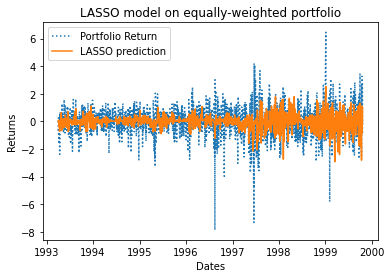

In [971]:
plt.figure()
plt.plot(result_p['Date'], result_p['Portfolio Returns'],':',  label = 'Portfolio Return')
plt.plot(result_p['Date'], result_p['Predicted Returns'], label = 'LASSO prediction')

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Returns')
plt.title('LASSO model on equally-weighted portfolio')
plt.show()

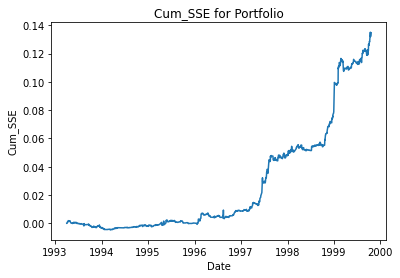

In [972]:
# Imagine an equally weighted index
# It gives us a pretty good conviction that we can predict an equally weighted indexes or ETFs
# by its components' different features and its technical indicators
# Again, the reason why we used equally weighted index is that because it's hard to beat it by any standards

plt.figure()
plt.plot(result_p['Date'], result_p['Cum_SSE'])

# plt.legend()

plt.xlabel('Date')
plt.ylabel('Cum_SSE')
plt.title('Cum_SSE for Equally Weighted Portfolio')
plt.axis('tight')
plt.show()

In [973]:
# plot the mse & log(alphas) in LASSO model
# inputs: stock index and its LASSO model

def plot_mse(i,LA_model):
    
    # This is to avoid division by zero while doing np.log10
    EPSILON = 1e-4
    # Display results
    m_log_alphas = -np.log10(LA_model.alphas_ + EPSILON)
    # print(m_log_alphas)

    plt.figure()
    plt.plot(m_log_alphas, LA_model.mse_path_, ':')
    plt.plot(m_log_alphas, LA_model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(LA_model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold for stock ' + str(i))
    plt.axis('tight')

Alpha of the best lasso regression:  1.4499150608906513


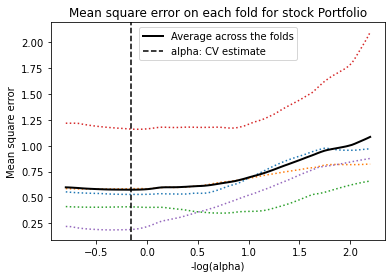

In [976]:
# Let's see what's going on with the best lasso model here (we actually took into account the best 10)
# It generates a positive alpha value

min_rmse = min(LA_rmse_p)
min_index = LA_rmse_p.index(min_rmse)
best_LASSO = LASSO_models_p[min_index]
print('Alpha of the best lasso regression: ', best_LASSO.alpha_)
plot_mse('Portfolio', best_LASSO)

# RANDOM FOREST WITH SELECTED FEATURES FROM LASSO

In [1162]:
# Import P_selected
# We are importing the features we will work on again..

P_selected = pd.read_excel('Portfolio_features_extraction_using_full_LASSO.xlsx', skiprows=range(1,4))
P_selected = P_selected.drop(columns=['Unnamed: 0']).dropna()
print(P_selected.shape)
P_selected.head()

(1904, 134)


,1_lag flow_portfolio,3_lag flow_portfolio,return_40970,return_62519,return_10302,return_67459,return_41355,return_70018,return_58800,return_48282,...,flow_59379,flow_75162,flow_27705,flow_54594,flow_48725,skewness,momentum_8_20,cumulative,rsi,stochastic
0,-1.371864,0.438636,0.0625,-0.020408,-0.052632,-0.009174,-0.011194,0.012195,-0.007792,0.014925,...,-3.424533,5.578285,6.493497,-1.218853,-0.945713,0.374748,0,0.989641,42.349771,0.157499
1,-1.615099,0.272253,0.0000,0.041667,-0.009259,0.000000,0.007547,-0.018072,-0.007853,0.058824,...,-3.425017,4.216083,-1.018682,-1.071887,0.344413,0.400713,0,0.992296,39.312262,-14.015594
2,-0.120668,-1.371864,0.0000,0.060000,0.009346,-0.009259,0.000000,0.009202,-0.018470,-0.027778,...,-8.719729,-5.975599,0.122558,18.260607,3.699671,0.362340,0,0.991519,42.810882,9.845382
3,-1.292642,-1.615099,0.0000,-0.056604,0.000000,-0.037383,0.007491,-0.009119,-0.032258,-0.014286,...,-2.221728,0.828145,9.054091,1.346347,-2.453187,0.275858,0,0.991884,42.046472,6.962355
4,0.097672,-0.120668,0.0000,-0.020000,-0.027778,-0.048544,0.007435,-0.052147,-0.002778,0.028986,...,-1.696613,-1.781644,-1.186732,-1.377242,-1.851283,0.319934,0,0.993253,42.564838,8.837603


In [1163]:
port_returns = pd.DataFrame(data = returns_.mean(axis=1), columns = ['Portfolio_returns'] )
# Import P_small
P_small = pd.read_csv('P_small.csv')
P_small['Portfolio_returns'] = np.zeros(shape=(len(P_small),1))
for i in range(len(port_returns)):
    P_small['Portfolio_returns'][i] = port_returns.iloc[i]
P_small = P_small[3:]  #excluding NA values because of 3-lags

<ipython-input-1163-55385417e57f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_small['Portfolio_returns'][i] = port_returns.iloc[i]


In [1173]:
# We will use P_select as our predictor
# Portfolio_return is what we want to predict, the other features are individual stocks' values that we found from
# the best lasso regressions above

P_select = pd.merge(P_small.iloc[:,-1], P_selected, left_index=True, right_index=True)
P_select = pd.merge(P_small.iloc[:,0], P_select, left_index=True, right_index=True)

P_select.head()

,Dates,Portfolio_returns,1_lag flow_portfolio,3_lag flow_portfolio,return_40970,return_62519,return_10302,return_67459,return_41355,return_70018,...,flow_59379,flow_75162,flow_27705,flow_54594,flow_48725,skewness,momentum_8_20,cumulative,rsi,stochastic
3,1993-04-06,-0.003143,-1.292642,-1.615099,0.000000,-0.056604,0.000000,-0.037383,0.007491,-0.009119,...,-2.221728,0.828145,9.054091,1.346347,-2.453187,0.275858,0,0.991884,42.046472,6.962355
4,1993-04-07,-0.000200,0.097672,-0.120668,0.000000,-0.020000,-0.027778,-0.048544,0.007435,-0.052147,...,-1.696613,-1.781644,-1.186732,-1.377242,-1.851283,0.319934,0,0.993253,42.564838,8.837603
5,1993-04-08,-0.000312,-1.001352,-1.292642,0.000000,-0.020408,0.019048,0.040816,-0.011070,0.006472,...,4.954451,0.329809,-0.356767,0.422362,1.404856,0.286453,1,1.000476,44.567460,17.856991
6,1993-04-12,0.011706,0.221467,0.097672,0.058824,-0.020833,0.074766,0.049020,0.007463,-0.003215,...,7.212195,33.134281,-0.060015,-2.228999,1.910914,0.268654,1,1.008275,53.734011,68.343875
7,1993-04-13,0.004415,0.765445,-1.001352,0.000000,-0.042553,-0.008696,0.028037,0.003704,-0.012903,...,-1.903223,1.396905,6.084005,-0.824906,0.467530,0.260252,1,1.010485,61.195394,171.978491


In [1193]:
def regress_rolling_p(df, start_index, window_size, grid):
    '''
    Parameters
    ----------
    df: dataframe
    start_index: int. When you want to start predicting from.
    window_size: int
    grid: dict for grid search

    '''
    regressor = RandomForestRegressor(n_estimators=100, random_state=random_state, oob_score=True, max_features='sqrt')
        
    temp_df = df.reset_index(drop=True)
    temp_df = temp_df.replace([np.inf, -np.inf], 0) # remove any infinity values
    #print(temp_df.head())
    scaler = preprocessing.StandardScaler() 
    looper = temp_df.Dates.iloc[start_index:].values # a list of dates to loop through

    models = []
    best_p = []
    dates = []
    train_MSE = []
    R2 = []
    mean_y = []
    Predicted_y = []
    True_y = []
    imp = []
    
    # rolling regression
    for i, date in enumerate(tqdm(looper)):
        end = temp_df[temp_df.Dates==date].index[0]
        start = end - window_size
        
        #the first 2 index is date and return, we don't need date and we will use return for Y values
        X = temp_df.iloc[start:end,2:]
        # we took returns here in the index below
        y = temp_df.iloc[start:end,1]
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
        
        X_train = X_scaled[:-1]
        y_train = y[:-1]
        X_test = X_scaled[-1:]
        y_test = y[-1:]
        
        CV_rf = GridSearchCV(estimator=regressor, param_grid=grid, refit=True)  
        CV_rf.fit(X_train, y_train.values.ravel())  
        
        models.append(CV_rf.best_estimator_)
        best_p.append(CV_rf.best_params_)
        y_pred = CV_rf.predict(X_test)
        dates.append(date)
        train_MSE.append(mean_squared_error(y_train, CV_rf.predict(X_train)))
        R2.append(r2_score(y_train, CV_rf.predict(X_train)))
        mean_y.append(y_train.mean())
        Predicted_y.append(y_pred[0])
        True_y.append(y_test.values[0])
        imp.append(CV_rf.best_estimator_.feature_importances_)
        
    result = pd.DataFrame(list(zip(dates,train_MSE,R2,mean_y,Predicted_y,True_y,best_p)), columns=['Date','MSE_train','R2_train','Historical_Mean','Predicted_Return','True_Return','Best_parameter'])
    return models, result, imp

In [1194]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import time

random_state = np.random.RandomState(0)

In [1195]:
start = time.process_time()
print("We now do regressions on equally-weighted portfolio.")

ws = 252
start_index = ws + 1
grid = {"min_samples_leaf": [1, 10, 20]}
models_p, result_p, feature_imp = regress_rolling_p(P_select,start_index, ws, grid)
 
# Notify user
end = time.process_time()
print("Regression done!")
print('Running time: %s mins'%round((end-start)/60,2))

We now do regressions on equally-weighted portfolio.



Regression done!
Running time: 91.56 mins


In [1196]:
result_p['diff_sse'] = (result_p.Historical_Mean - result_p.True_Return)**2/len(result_p) - (result_p.Predicted_Return - result_p.True_Return)**2/len(result_p)
result_p['Cum_SSE_diff'] = np.cumsum(result_p.diff_sse) 
result_p.head()

,Date,MSE_train,R2_train,Historical_Mean,Predicted_Return,True_Return,Best_parameter,diff_sse,Cum_SSE_diff
0,1994-04-06,0.000021,0.215081,0.000436,0.000015,0.024834,{'min_samples_leaf': 20},-1.257510e-08,-1.257510e-08
1,1994-04-07,0.000023,0.205737,0.000536,-0.000391,0.000575,{'min_samples_leaf': 20},-5.651307e-10,-1.314023e-08
2,1994-04-08,0.000023,0.210251,0.000539,0.000513,0.006786,{'min_samples_leaf': 20},-1.969950e-10,-1.333722e-08
3,1994-04-11,0.000023,0.216330,0.000520,0.000170,-0.008506,{'min_samples_leaf': 20},3.754581e-09,-9.582641e-09
4,1994-04-12,0.000023,0.214447,0.000468,0.000400,0.001681,{'min_samples_leaf': 20},-1.031980e-10,-9.685839e-09


In [1197]:
result_out = result_p.copy(deep=True)
result_out['model'] = models_p
result_out.head()

,Date,MSE_train,R2_train,Historical_Mean,Predicted_Return,True_Return,Best_parameter,diff_sse,Cum_SSE_diff,model
0,1994-04-06,0.000021,0.215081,0.000436,0.000015,0.024834,{'min_samples_leaf': 20},-1.257510e-08,-1.257510e-08,"(DecisionTreeRegressor(max_features='sqrt', mi..."
1,1994-04-07,0.000023,0.205737,0.000536,-0.000391,0.000575,{'min_samples_leaf': 20},-5.651307e-10,-1.314023e-08,"(DecisionTreeRegressor(max_features='sqrt', mi..."
2,1994-04-08,0.000023,0.210251,0.000539,0.000513,0.006786,{'min_samples_leaf': 20},-1.969950e-10,-1.333722e-08,"(DecisionTreeRegressor(max_features='sqrt', mi..."
3,1994-04-11,0.000023,0.216330,0.000520,0.000170,-0.008506,{'min_samples_leaf': 20},3.754581e-09,-9.582641e-09,"(DecisionTreeRegressor(max_features='sqrt', mi..."
4,1994-04-12,0.000023,0.214447,0.000468,0.000400,0.001681,{'min_samples_leaf': 20},-1.031980e-10,-9.685839e-09,"(DecisionTreeRegressor(max_features='sqrt', mi..."


In [1198]:
result_out.to_csv('random_forest_result.csv')

In [1199]:
start = time.process_time()
print("We now do regressions on equally-weighted portfolio.")

ws = 252
start_index = int(ws*7.5) + 1
grid = {"min_samples_leaf": [1, 10, 20]}
model_add, result_add, importance = regress_rolling_p(P_select,start_index, ws, grid)
 
# Notify user
end = time.process_time()
print("Regression done!")
print('Running time: %s mins'%round((end-start)/60,2))

We now do regressions on equally-weighted portfolio.



Regression done!
Running time: 0.45 mins


In [1200]:
result_add.tail()

,Date,MSE_train,R2_train,Historical_Mean,Predicted_Return,True_Return,Best_parameter
5,2000-10-06,0.000050,0.371853,0.000735,0.001361,-0.002149,{'min_samples_leaf': 10}
6,2000-10-09,0.000062,0.216009,0.000710,-0.000027,-0.009062,{'min_samples_leaf': 20}
7,2000-10-10,0.000050,0.379218,0.000656,-0.000992,-0.001014,{'min_samples_leaf': 10}
8,2000-10-11,0.000049,0.383808,0.000695,0.000544,-0.011072,{'min_samples_leaf': 10}
9,2000-10-12,0.000064,0.199580,0.000691,-0.000120,-0.011464,{'min_samples_leaf': 20}


In [1201]:
feature_name = P_selected.columns.to_list()
feature_imp = pd.DataFrame(importance, columns=feature_name)

feature_imp.head()

,1_lag flow_portfolio,3_lag flow_portfolio,return_40970,return_62519,return_10302,return_67459,return_41355,return_70018,return_58800,return_48282,...,flow_59379,flow_75162,flow_27705,flow_54594,flow_48725,skewness,momentum_8_20,cumulative,rsi,stochastic
0,0.005687,0.003038,0.002844,0.013254,0.005640,0.008365,0.010999,0.004108,0.009763,0.008852,...,0.013576,0.001930,0.004547,0.002766,0.008128,0.008567,0.000000,0.003767,0.002464,0.010805
1,0.005087,0.006070,0.001361,0.013507,0.007541,0.009449,0.009240,0.006434,0.009202,0.002661,...,0.012991,0.004653,0.007812,0.004368,0.004531,0.005264,0.000000,0.005973,0.004638,0.014688
2,0.000829,0.007690,0.000000,0.021818,0.010247,0.011574,0.001517,0.003228,0.005135,0.003650,...,0.019026,0.004157,0.016045,0.001131,0.006344,0.002312,0.000929,0.001849,0.009016,0.003384
3,0.004481,0.014919,0.001670,0.030152,0.003388,0.011068,0.000000,0.002932,0.011621,0.005572,...,0.006242,0.014781,0.005160,0.001830,0.002549,0.004380,0.003254,0.003726,0.009355,0.007991
4,0.004266,0.008320,0.002098,0.028897,0.001952,0.013263,0.006607,0.003145,0.011869,0.000000,...,0.004432,0.010277,0.015192,0.003467,0.008124,0.004431,0.000000,0.007744,0.008010,0.008074


In [1202]:
imp_mean = feature_imp.mean()
imp_mean = pd.DataFrame(imp_mean.sort_values(ascending=False), columns=['avg importance'])

In [1203]:
# However our logic, steps and conclusion is the same, as you can realize here (this is correct version)
# So, lagged flows and returns of the stocks are beneficial to predict the equal weighted index's returns
# Beating equal weighted index is hard, if you can have a good model to predict index, you can apply it to individual stocks as well

imp_mean.head(10)

,avg importance
flow_67459,0.025098
flow_41072,0.024943
flow_63829,0.019608
flow_27887,0.019294
return_62519,0.017364
return_64995,0.016131
flow_23077,0.016097
flow_63554,0.015031
flow_27684,0.014843
return_67563,0.014078


# MLP Regression using grid search with rolling window

In [1208]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

In [1209]:
# Let's see how neural networks are doing with a similar code, just out of curiosity
# We tried many window sizes before, as you can also realize in the slides, the larger window size is
# much better for prediction, so we trained our model based on the last 1 year figures

window_size = 252
dates = []
grid_models_p = []
grid_predict = []
grid_y_test = []
historical_mean = []
grid_mse_p = []
grid_rmse_p = []

# Rolling window
for n in tqdm(range(1, len(portfolio)-window_size)):
    dates.append(portfolio.index[n])
    n_train = P_full.iloc[n:n+window_size]
    n_test = P_full.iloc[n+window_size]
    ny_train = py.iloc[n:n+window_size]
    ny_test = py.iloc[n+window_size]

#   Grid search for optimal hyperparameter
#     layer_size = [(100,)]
    layer_size = [(ls,) for ls in range(100,500,100)]
#     activation_option = ['tanh', 'relu']
    activation_option = ['tanh']
    solver_option = ['lbfgs']
#     solver_option = ['adam','lbfgs']
    para_grid = {'hidden_layer_sizes': layer_size, 'activation': activation_option, 'solver': solver_option}
    #     MLPR model with cross-validation of 5-fold
    MLPR = MLPRegressor(alpha = 0.0001, max_iter = 1000, shuffle = False)
    grid = GridSearchCV(MLPR, para_grid, cv = 5)
    grid.fit(n_train, ny_train.values.ravel())
    grid_models_p.append(grid)
#     Rolling window prediction
    ny_pred = grid.predict(n_test.values.reshape(1,-1))
    grid_predict.append(ny_pred[0])
    grid_y_test.append(ny_test[0])
    historical_mean.append(ny_train.mean()[0])
#     MSE and RMSE
    mse = mean_squared_error(ny_pred, ny_test)
    grid_mse_p.append(mse)
    rmse = sqrt(mse)
    grid_rmse_p.append(rmse)
    

# The algorithm stopped running at this time (we ran this for 2hours 43 minutes, so we didn't have chance to re-run this)
# However, the results are saved so we can still evaluate the goodness of the results

IndexError: single positional indexer is out-of-bounds

In [1211]:
# output the results from above algorithm
result_p1 = pd.DataFrame(list(zip(dates,grid_models_p, grid_predict, grid_y_test, historical_mean,grid_mse_p, grid_rmse_p)), columns=['Date','Grid-MLPR models','Predicted Returns','Portfolio Returns', 'Historical Mean', 'MSE','RMSE'])


# Compute the differense of out-of-sample SSE bewteen historical mean and predicted returns
result_p1['diff_SSE'] = (result_p1['Historical Mean'] - result_p1['Portfolio Returns'])**2/len(result_p1['Portfolio Returns']) - (result_p1['Predicted Returns'] - result_p1['Portfolio Returns'])**2/len(result_p1['Portfolio Returns'])
# compute the cumulative out-of-sample SSE difference
result_p1['Cum_SSE'] = np.cumsum(result_p1.diff_SSE) 
print(result_p1.head())


# Export results dataframe for further usage
result_p1.to_excel('Grid-MLPR_portfolio_results.xlsx', index = False)

        Date                                   Grid-MLPR models  \
0 1993-04-02  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
1 1993-04-05  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
2 1993-04-06  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
3 1993-04-07  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
4 1993-04-08  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   

   Predicted Returns  Portfolio Returns  Historical Mean       MSE      RMSE  \
0           0.835295          -0.670150        -0.025053  2.266366  1.505445   
1           2.439123           0.257323        -0.026021  4.760252  2.181800   
2          -0.835520          -0.765451        -0.024664  0.004910  0.070069   
3          -1.220246          -1.610967        -0.025558  0.152663  0.390721   
4           0.562833          -1.183074        -0.033015  3.048194  1.745908   

   diff_SSE   Cum_SSE  
0 -0.001119 -0.001119  
1 -0.002829 -0.003948  
2  0.000329 -0.003619  
3  0.001427 -0.00219

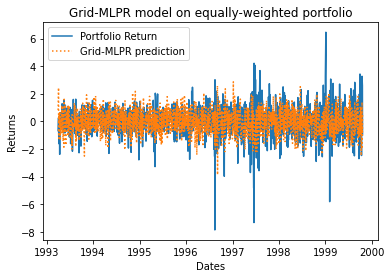

In [1212]:
plt.figure()
plt.plot(result_p1['Date'], result_p1['Portfolio Returns'],  label = 'Portfolio Return')
plt.plot(result_p1['Date'], result_p1['Predicted Returns'], ':', label = 'Grid-MLPR prediction')

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Returns')
plt.title('Grid-MLPR model on equally-weighted portfolio')
plt.show()

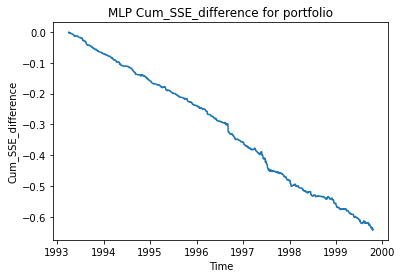

In [1213]:
#plot OOS SSE

plt.figure()
plt.plot(result_p1['Date'], result_p1['Cum_SSE'])

# plt.legend()

plt.xlabel('Time')
plt.ylabel('Cum_SSE_difference')
plt.title('MLP Cum_SSE_difference for portfolio')
plt.axis('tight')
plt.show()

In [1217]:
# select the best hyperparameter (this time with the minimum rmse, because the model is already not doing a great job)
# For MLPR regression by RMSE
min_rmse_ = min(grid_rmse_p)
min_index_ = grid_rmse_p.index(min_rmse_)
best_MLPR = grid_models_p[min_index_]

In [1218]:
best_MLPR.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (300,), 'solver': 'lbfgs'}

In [1219]:
best_MLPR.cv_results_

{'mean_fit_time': array([0.13304982, 0.18332667, 0.26573787, 0.35147429]),
 'std_fit_time': array([0.0510942 , 0.04894993, 0.06707795, 0.04844218]),
 'mean_score_time': array([0.00258298, 0.00281982, 0.00293412, 0.00312862]),
 'std_score_time': array([1.07883119e-04, 3.42208305e-04, 1.54354597e-04, 5.12580206e-05]),
 'param_activation': masked_array(data=['tanh', 'tanh', 'tanh', 'tanh'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(100,), (200,), (300,), (400,)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'activation': 'tanh',
   'hidden_layer_sizes': (100,),
   'solver': 'lbfgs'},
  {'activation': 'tanh', 'hidden_layer_sizes': (200,), 'solve